In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from lorenz_data.data_generator import data_generator_sde
from lorenz_data.data_generator import euler_sde
from lorenz_data.data_generator import euler_sde_net
from lorenz_data.data_generator import euler
import sys
import os

In [2]:
sys.path.append("../src")
sys.path.append("../src/onetlib")

In [3]:
import onsagernet as onet

## Toy example: 1D

We consider the SDE:
$$
dx_t = f(x_t)dt + \sigma(x_t) d W_t
$$
Here $x_t,f(x_t),\sigma(x_t)$ are 1-dimensional.

$W_t$ is Brownian motion which satisfies $W_i(t)-W_i(s) \sim \mathcal{N}(0,t-s),t>s$.

We assume $f(x_t) = -2x_t^3-4x_t+1.5,\sigma(x_t) = 0.05x_t + 0.5$.

### Data generation

We want to generalize $N$ snapshots $D = \{(x^{(k)},y^{(k)},h^{(k)}\ )\}_{k=1}^{N}$  ,where  $x^{(k)}$ are points scattered in the state space $\mathbb{R}$ of the SDE system.The $N$ datapoints $x^{(k)}$ are used as the input variables of our neural network. $y^{(k)}$ results from the evolution the SDE system under a small time-step $h^{(k)}>0$, starting at $x^{(k)}$. $N$ datapoints $y^{(k)}$ are used as the output variables accordingly. $x^{(k)}$ are sampled from a distribution $f_0(x)$, and $h^{(k)}$ are sampled from distribution $f_h$. Note that the step size $h^{(k)}$ may not be a constant.

We assume $f_0$ is uniformly distributed over $[-2,2]$, and $h$  equals to the constant $0.005$.


In [4]:
def drift(u):
    return np.array([-2*u**3-4*u+1.5])
def diffusitivity(u):
    return np.array([0.05*u+0.5])
delta_t = 0.005

Let's have a look at the solution to the SDE first. We use traditional numerical Euler-Maruyame scheme to solve the SDE system and observe the solution.

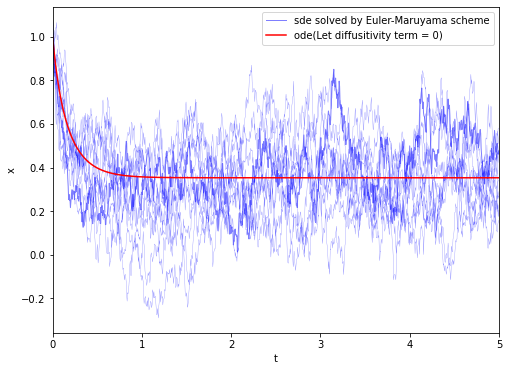

In [5]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)

for i in range(10):
    t,u = euler_sde(drift,diffusitivity,u0 = np.array([1]),delta_t = delta_t,N = 1000,n_dim = 1)
    axes.plot(t,u,'b',linewidth = 0.3,alpha = 0.5)
t,u = euler_sde(drift,diffusitivity,u0 = np.array([1]),delta_t = delta_t,N = 1000,n_dim = 1)
axes.plot(t,u[:,0],'b',linewidth = 1,alpha = 0.5,label = 'sde solved by Euler-Maruyama scheme')

t,u= euler(drift,u0 = np.array([1]), t_span = (0,10),N = 100000,n_dim = 1)
axes.plot(t,u,'r',label = 'ode(Let diffusitivity term = 0)')
axes.set_xlabel('t')
axes.set_ylabel('x')
axes.set_xlim([0,5])
axes.legend()
plt.show()

In [6]:
tf.random.set_seed(1)
n_samples = 1000*500
n_dim = 1

X_data = tf.random.uniform(shape = (n_samples,n_dim),minval = -2, maxval = 2)
h = tf.ones((n_samples,1))*0.005
Data_generator = data_generator_sde(drift = drift, diffusitivity = diffusitivity)
Y_data = Data_generator.euler_sde(X_data,h)

In [7]:
np.savez('lorenz_data/sde_id.npz',X_data = X_data, Y_data  = Y_data)

In [8]:
# Load data
path = 'lorenz_data/sde_id.npz'
with np.load(path) as data:
    X_data = data['X_data']
    Y_data = data['Y_data']

In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(
    np.array(X_data),np.array(Y_data),test_size=0.3,shuffle = True
)   

In [10]:
Y_test.shape

(150000, 1)

## Build model

In [11]:
beta = 0.1
alpha = 0.01
n_features = 1

pot_layer_size = [16,16,4,4]
dc_layer_sizes = [16,16,4]
fc_layer_sizes = [16,16,4,4]
diffu_layer_sizes = [16]

In [12]:
# build Onsager net 
def build_onsager_net():
    # choose the activation function of FCPotentialNet to be tanh
    # tanh activation functiong works better on the DNA demo
    potential_net = onet.FCPotentialNet(beta = beta,
                                       layer_sizes = pot_layer_size,
                                       n_pot = n_features)
    dissconv_net = onet.FCDissConsNet(n_dim = n_features,
                                     layer_sizes = dc_layer_sizes)
    forcing_net = onet.FCForcingNet(n_dim = n_features,layer_sizes = fc_layer_sizes)
    onsager_net = onet.OnsagerNet(n_dim = n_features,
                                  potential_net = potential_net,
                                  dissconv_net = dissconv_net,
                                  forcing_net = forcing_net,
                                  alpha = alpha)
    
    DiffusitivityNet = onet.DiffusitivityNet(n_dim = n_features,layer_sizes = diffu_layer_sizes,mode = 'arbitrary')
    
    inputs = tf.keras.Input((n_features,))
    outputs = tf.concat([inputs,onsager_net(inputs),DiffusitivityNet(inputs)],1)
    OnsagerNet = tf.keras.Model(inputs,outputs,name = 'onsager_rhs')
    return OnsagerNet

In [13]:
model = onet.SDEOnsagerNet(n_features = n_features,delta_t = delta_t, OnsagerNet = build_onsager_net())
model.build(input_shape = (None,n_features))
model.summary()

Model: "sde_onsager_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 onsager_rhs (Functional)    (None, 3)                 1220      
                                                                 
Total params: 1,220
Trainable params: 1,220
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = onet.CustomEulerLoss(epsilon = 1e-4,n_features = n_features,delta_t = delta_t))

In [15]:
model.evaluate(X_train,Y_train)

10938/10938 [==============================] - 15s 1ms/step - loss: 4509301248.0000


4509301248.0

Let's have a look at the predicted drift $f(x)$ and diffusitivity $\sigma(x)$ before traing the neural network.

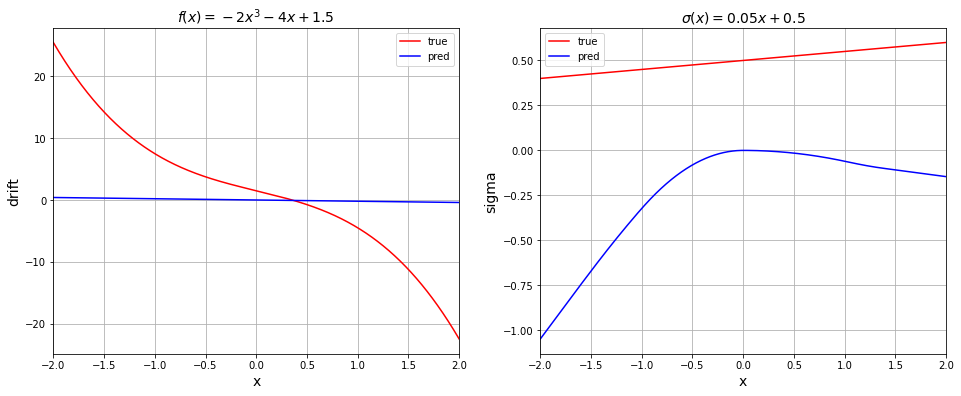

In [16]:
x = np.linspace(-2,2,1000)
x = x.reshape((-1,1))
drift_true = -2*x**3-4*x+1.5
sigma_true = 0.05*x + 0.5
pred = model.call(x)
drift_pred = pred[:,n_features:2*n_features]
sigma_pred = pred[:,2*n_features:]

fig = plt.figure(figsize = (16,6))
axes = fig.add_subplot(1,2,1)
axes.plot(x,drift_true,'r',label = 'true')
axes.plot(x,drift_pred,'b',label = 'pred')
axes.set_xlabel('x',fontsize = 14)
axes.set_ylabel('drift',fontsize = 14)
axes.set_title('$f(x) = -2x^3-4x+1.5$',fontsize = 14)
axes.set_xlim(-2,2)
axes.grid()
axes.legend()

axes = fig.add_subplot(1,2,2)
axes.plot(x,sigma_true,'r',label = 'true')
axes.plot(x,sigma_pred,'b',label = 'pred')
axes.set_xlabel('x',fontsize = 14)
axes.set_ylabel('sigma',fontsize = 14)
axes.set_title('$\sigma(x) = 0.05x+0.5$',fontsize = 14)
axes.set_xlim(-2,2)
axes.grid()
axes.legend()
plt.show()

In [17]:
# set learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.4, patience = 2, min_lr = 1e-7)
history = model.fit(x = X_train,
                    y = Y_train,
                    validation_data = (X_test,Y_test),
                    batch_size= 32,
                    epochs = 20,
                    callbacks = lr)

Epoch 1/20
10938/10938 [==============================] - 37s 3ms/step - loss: -3.7098 - val_loss: -3.8300 - lr: 0.0100
Epoch 2/20
10938/10938 [==============================] - 34s 3ms/step - loss: -3.8460 - val_loss: -3.8513 - lr: 0.0100
Epoch 3/20
10938/10938 [==============================] - 37s 3ms/step - loss: -3.8481 - val_loss: -3.8442 - lr: 0.0100
Epoch 4/20
10938/10938 [==============================] - 38s 3ms/step - loss: -3.8488 - val_loss: -3.8513 - lr: 0.0100
Epoch 5/20
10938/10938 [==============================] - 38s 3ms/step - loss: -3.8556 - val_loss: -3.8520 - lr: 0.0040
Epoch 6/20
10938/10938 [==============================] - 38s 3ms/step - loss: -3.8559 - val_loss: -3.8539 - lr: 0.0040
Epoch 7/20
10938/10938 [==============================] - 39s 4ms/step - loss: -3.8559 - val_loss: -3.8488 - lr: 0.0040
Epoch 8/20
10938/10938 [==============================] - 39s 4ms/step - loss: -3.8558 - val_loss: -3.8544 - lr: 0.0040
Epoch 9/20
10938/10938 [================

Note that the loss maybe less than 0. This is because we use the loss $-log(p)$, wheree $p$ is the probability density function of normal distribution, hence the loss maybe smaller than 0.
$$\mathcal{L}(\theta|y^{(k)},x^{(k)},h) = \frac{(y^{(k)}-x^{(k)}\ -hf_{\theta} \ (x^{\  (k)}\ ) \ )^2}{h\sigma_{\theta} \ (x^{(k)})^2}+log|h\sigma_{\theta}(x^{(k)})^2| + log(2 \pi)$$

In [18]:
x = np.linspace(-2,2,1000)
x = x.reshape((-1,1))
drift_true = -2*x**3-4*x+1.5
sigma_true = 0.05*x + 0.5
pred = model.call(x)
drift_pred = pred[:,n_features:2*n_features]
sigma_pred = pred[:,2*n_features:]

Let's have a look at the predicted drift $f(x)$ and diffusitivity $\sigma(x)$ **after** traing the neural network.

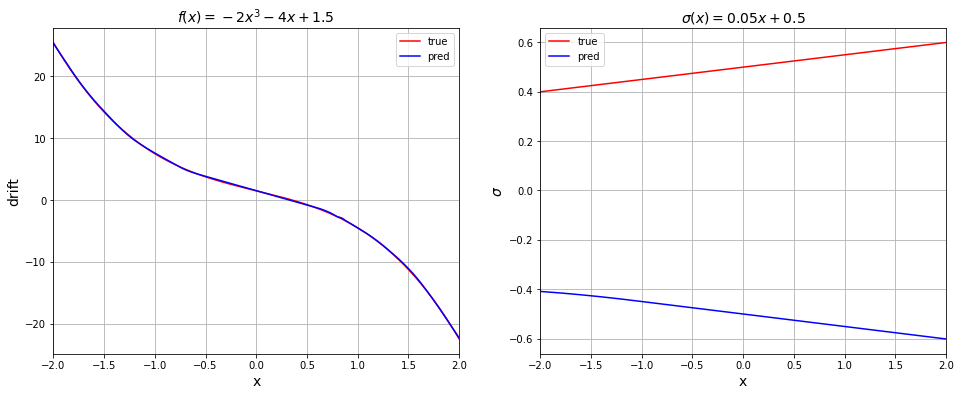

In [26]:
x = np.linspace(-2,2,1000)
x = x.reshape((-1,1))
drift_true = -2*x**3-4*x+1.5
sigma_true = 0.05*x + 0.5
pred = model.call(x)
drift_pred = pred[:,n_features:2*n_features]
sigma_pred = pred[:,2*n_features:]

fig = plt.figure(figsize = (16,6))
axes = fig.add_subplot(1,2,1)
axes.plot(x,drift_true,'r',label = 'true')
axes.plot(x,drift_pred,'b',label = 'pred')
axes.set_xlabel('x',fontsize = 14)
axes.set_ylabel('drift',fontsize = 14)
axes.set_title('$f(x) = -2x^3-4x+1.5$',fontsize = 14)
axes.set_xlim(-2,2)
axes.grid()
axes.legend()

axes = fig.add_subplot(1,2,2)
axes.plot(x,sigma_true,'r',label = 'true')
axes.plot(x,sigma_pred,'b',label = 'pred')
axes.set_xlabel('x',fontsize = 14)
axes.set_ylabel('$\sigma$',fontsize = 14)
axes.set_title('$\sigma(x) = 0.05x+0.5$',fontsize = 14)
axes.set_xlim(-2,2)
axes.grid()
axes.legend()
plt.show()

We can observe from the figure that the predicted $f(x)$ corrdinates rather well with the true $f(x)$. However, the predicted $\sigma(x)$ seems to be the negative of the true $\sigma(x)$. Since we can only predict $\sigma(x)\sigma(x)^T$ precisely, in 1-dimension case, we can only predict $|\sigma(x)|$ precisely.

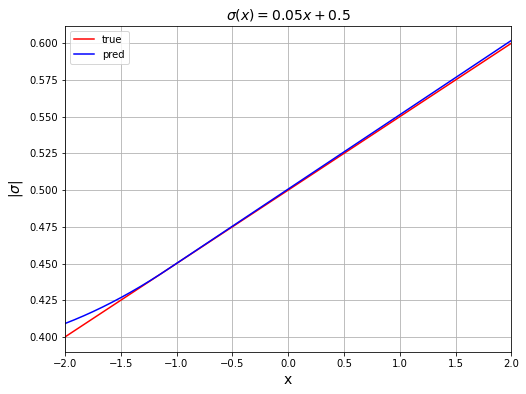

In [24]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)
axes.plot(x,np.abs(sigma_true),'r',label = 'the absolute value of true')
axes.plot(x,np.abs(sigma_pred),'b',label = 'the absolute value of pred')
axes.set_xlabel('x',fontsize = 14)
axes.set_ylabel('$|\sigma|$',fontsize = 14)
axes.set_title('$\sigma(x) = 0.05x+0.5$',fontsize = 14)
axes.set_xlim(-2,2)
axes.grid()
axes.legend()
plt.show()

we can observe that the predicted $\sigma(x)$ matches with the true $|\sigma(x)|$.

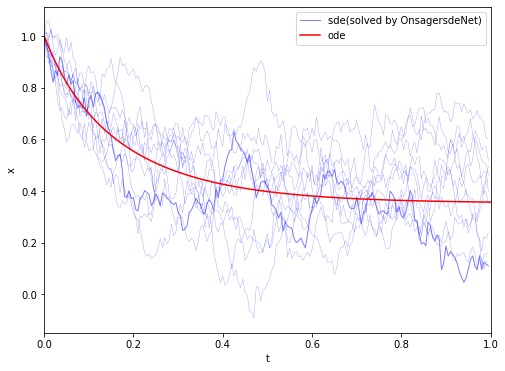

In [20]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)
for i in range(10):
    t,u = euler_sde_net(model,u0 = np.array([1]),delta_t = delta_t,N = 200,n_dim = 1)
    axes.plot(t,u,'b',linewidth = 0.3,alpha = 0.5)
    
t,u = euler_sde_net(model,u0 = np.array([1]),delta_t = delta_t,N = 200,n_dim = 1)
axes.plot(t,u,'b',linewidth = 1,alpha = 0.5,label = 'sde(solved by OnsagersdeNet)')
t,u= euler(drift,u0 = np.array([1]), t_span = (0,1),N = 10000,n_dim = 1)
axes.plot(t,u,'r',label = 'ode')
axes.set_xlabel('t')
axes.set_ylabel('x')
axes.set_xlim([0,1])
axes.legend()
plt.show()